# Convolutional Networks

Before we start, we should assure that we have activated CUDA -- otherwise training might take very long.
In Google Colaboratory:

1. Check the options Runtime -> Change Runtime Type on top of the page.
2. In the popup window, select hardware accelerator GPU.

Afterward, the following command should run successfully:

In [1]:
import torch
if torch.cuda.is_available():
  print("Successfully enabled CUDA processing")
else:
  print("CUDA processing not available. Things will be slow :-(")

CUDA processing not available. Things will be slow :-(


## Dataset

In PyTorch, a dataset stores a list of input and target tensors $(X^n, T^n)$.
In case of **MNIST** dataset, the inputs are $X^n \in \mathbb R^{28\times28}$ and $T^n \in \{0,\ldots,9\}$.
More precisely, the data in the dataset is provided in form of `PIL.Image.Image`, which represents an image class with some more functionality, and pixel values in range $[0, 255]$.
In order to convert these images into `torch.Tensor`'s in range $[0,1]$, we can use the [ToTensor](https://pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html) transform.
Furthermore, in `PyTorch` batches are created from datasets using the [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) class.


### Task 1: Dataset Loading


Here, we use the [MNIST dataset](https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html) of gray images for categorical classification.

Write a function that returns the training and the testing set of MNIST, using the given transform.

In [2]:
import torch
import torchvision

def datasets(transform):
  # Use a relative path to save data in the current project directory
  trainset = torchvision.datasets.MNIST(
      root="./data/MNIST",  # Corrected path
      train=True, download=True,
      transform=transform)
  testset = torchvision.datasets.MNIST(
      root="./data/MNIST",  # Corrected path
      train=False, download=True,
      transform=transform)

  return trainset, testset


### Test 1: Data Types

When we create the dataset with `transform=None`, all inputs shall be of type `PIL.Image.Image`, and all targets are integral.

In [3]:
import PIL
trainset, testset = datasets(transform=None)

for x,t in trainset:
  # check datatype of input x
  assert isinstance(x, PIL.Image.Image)
  # check datatype of target t
  assert isinstance(t, int)

### Task 2: Data Loaders


Create the dataset with transform `ToTensor`. Create two data loaders, one for the training set and one for the testing set. The training batch size should be $B=64$, for the testing set, you can select any batch size of your choice.


In [4]:
transform =  torchvision.transforms.ToTensor()
trainset, testset = datasets(transform=transform)

B = 64
trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=B)
testloader = torch.utils.data.DataLoader(testset, shuffle=False, batch_size=128)



### Test 2: Batches

Check that all batches generated by the training set data loader have the batch size of $B$ -- except for the last batch, which you need to compute by yourself (you might want to make use of the modulo operator `%`).

Afterward, we check that all inputs and targets are of type `torch.Tensor`, that all input values are in range $[0,1]$ and that all target values are in range $[0,9]$.

In [5]:
# compute the size of last batch
last_batch = len(trainset)%64

for x,t in trainloader:
  # check datatype, size and content of x
  assert isinstance(x, torch.Tensor)
  assert(torch.all(x >= 0)) and torch.all(x <= 1)  
  assert len(x)==B or len(x) == last_batch

  # check datatype, size and content of t
  assert isinstance(t, torch.Tensor)
  assert(torch.all(t >= 0)) and torch.all(t <= 9)
  assert len(t)==B or len(t) == last_batch

## Networks
As last week, we will rely on [Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) to create networks with particular lists of consecutive layers.
Particularly, we will investigate two different versions of networks, one fully-connected network and one convolutional network, with the same number of learnable layers.

### Task 3: Fully-Connected Network


Implement a function that returns a three-layer fully-connected network in `pytorch`.
Use $\tanh$ as activation function between the two fully-connected layers, and provide the possibility to change the number of inputs $D$, the number of hidden neurons $K$ and the number of outputs $O$.
Use the following layers:

1. A [Flatten layer](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html) to turn the $28\times28$ pixel image (2D) into a $28\cdot28$ pixel vector (1D).
2. A [fully-connected layer](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) with D input neurons and K outputs.
3. A [$\tanh$ activation function](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html).
4. A fully-connected layer with K input neurons and K outputs.
5. A $\tanh$ activation function.
6. A fully-connected layer with K input neurons and O outputs.

In [6]:
def fully_connected(D, K, O):
  return torch.nn.Sequential(
    torch.nn.Flatten(), 
    torch.nn.Linear(D, K),
    torch.nn.Tanh(),
    torch.nn.Linear(K, K),
    torch.nn.Tanh(),
    torch.nn.Linear(K, O)
    )

### Task 4: Convolutions Output (theoretical question)

Consider the network as defined in Task 5.
Assume that the input is a $28\times28$ grayscale image.
How many hidden neurons do we need in the final fully-connected layer for a given number $Q_2$ of output channels of the second convolution?

We found two ways to compute this. The first and easy way is just to let pytorch figure it out since (still before having the linear layer added to the network design), after running the flatten function, we are transforming the feature map of the previous layer into 1D, running the network and checking the output size will yield the number of needed neurons: e.g., z = cv(x) then z.shape = (1568, 1). We can use this number for the hidden neurons of the linear layer. The 2nd way we can compute it is by hand since it's a small network given the formula for the output shape: (W-K+2P)/S + 1: W for the input shape, K: the size of the kernel, P: for padding and S: for striding. Applying this over our network, the last layer shape will be (7,7,32) (ignoring the batch size). Flatting this yields 1568 neurons needed. 

### Task 5: Convolutional Network

Implement a function that generates a convolutional network with the following layers:

1. A [2D convolutional layer](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) with $Q_1$ channels, kernel size $5\times5$, stride 1 and padding 2.
2. A [2D maximum pooling](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) with pooling size $2\times2$ and stride 2.
3. A $\tanh$ activation function.
4. A 2D convolutional layer with $Q_2$ channels, kernel size $5\times5$, stride 1 and padding 2.
5. A 2D maximum pooling with pooling size $2\times2$ and stride 2.
6. A $\tanh$ activation function.
7. A flattening layer to turn the 3D feature map into a 1D vector.
8. A fully-connected layer with the appropriate number of inputs and $O$ outputs.

In [7]:
def convolutional(Q1, Q2, O):
  return torch.nn.Sequential(
        torch.nn.Conv2d(in_channels=1, out_channels=Q1, kernel_size=5, stride=1, padding=2),
        torch.nn.MaxPool2d(kernel_size=2, stride=2),
        torch.nn.Tanh(),
        torch.nn.Conv2d(in_channels=Q1, out_channels=Q2, kernel_size=5, stride=1, padding=2),
        torch.nn.MaxPool2d(kernel_size=2, stride=2),
        torch.nn.Tanh(),
        torch.nn.Flatten(),
        torch.nn.Linear(in_features=Q2 * 7 * 7, out_features=O)
  )

## Network Training
For training and evaluating the network, we rely on standard functionality in PyTorch.
We use the standard [categorical cross-entropy loss](https://pytorch.org/docs/stable/nn.html#loss-functions) together with a [stochastic gradient descent](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) optimizer.
For training, we use the batched implementation of the dataset, for which we perform one update step for each training batch.
After having gone through the full training dataset, we compute accuracy and loss values for the testing set (we simply make use of the testing set for validation).


### Task 6: Training and Validation Loop

Implement a function that takes the network, the number of epochs, and the learning rate.
Select the correct loss function for categorical classification and SGD optimizer.
Iterate the following steps for the given number of epochs:

1. Train the network with all batches of the training data.
2. Compute the testing set loss and testing set accuracy.
3. Store both in a vector.

What do we need to take care of?

Finally, return the lists of validation losses and accuracies.

In [8]:
def train(network, epochs, eta, momentum):
  from tqdm.notebook import tqdm
  # select loss function and optimizer
  loss = torch.nn.CrossEntropyLoss()
  
  optimizer = torch.optim.SGD(
      params=network.parameters(),
      lr=eta, momentum=momentum
  )

  # --- CORRECTED DEVICE SELECTION ---
  # Automatically select the best available device
  if torch.backends.mps.is_available():
      device = torch.device("mps")
  else:
      device = torch.device("cpu")
  
  print(f"Using device: {device}") # Helpful print statement
  
  network = network.to(device)

  # collect loss values and accuracies over the training epochs
  val_loss, val_acc = [], []
  tqdmo_epoch = tqdm(range(epochs), desc="Epochs")
  for epoch in tqdmo_epoch:
    # train network on training data
    for x,t in trainloader:
      # train
      optimizer.zero_grad()
      
      z = network(x.to(device))
      J = loss(z, t.to(device))

      J.backward()
      optimizer.step()

    # test network on test data
    with torch.no_grad():
      total_correct = 0
      total_loss = 0
      n_batches = 0
      total_samples= 0
      for x,t in testloader:
        # compute validation loss
        z = network(x.to(device))
        J = loss(z, t.to(device))
        total_loss += J.item()
        n_batches += 1
        # compute validation accuracy
        total_correct += torch.sum(torch.argmax(z, dim=1) == t.to(device)).item()
        total_samples+= x.size(0)

      val_loss.append(total_loss/n_batches)
      val_acc.append(total_correct / total_samples)

  # return loss and accuracy values
  return val_loss, val_acc

### Task 7: Fully-Connected Training

Create a fully-connected network with $K=100$ hidden and $O=10$ output neurons.
Train the network for 10 epochs with $\eta=0.01$, $momentum=0.9$ and store the obtained test losses and accuracies.
Brave people can also train for 100 epochs (which will take up to 30 minutes).

In [9]:
import time
fc = fully_connected(28*28, 100, 10)
start = time.time()
fc_loss, fc_acc = train(fc, 60, 0.01, 0.9)
print(f"Computation time {time.time() - start}")

Using device: cpu


Epochs:   0%|          | 0/60 [00:00<?, ?it/s]

Computation time 510.8492901325226


### Task 8: Convolutional Training


Create a convolutional network with $Q_1=16$ and $Q_2=32$ convolutional channels and $O=10$ output neurons.
Train the network for 10 epochs with $\eta=0.01$, momentum $=0.9$ and store the obtained test losses and accuracies.
Again, 100 epochs will take up to 30 minutes.

In [10]:
cv = convolutional(16, 32, 10)
start = time.time()
cv_loss, cv_acc = train(cv, 60, 0.01, 0.9)
print(f"Computation time {(time.time() - start)/60} minutes")

Using device: cpu


Epochs:   0%|          | 0/60 [00:00<?, ?it/s]

Computation time 22.277923866113028 minutes


### Task 9: Plotting

Plot the two lists of loss values in one plot. Plot the two lists of accuracy values into another plot.

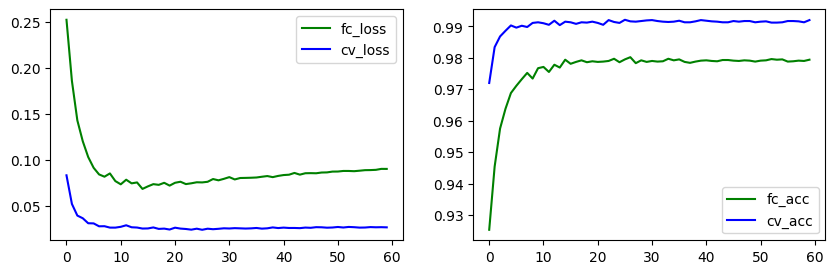

In [11]:
from matplotlib import pyplot
pyplot.figure(figsize=(10,3))
ax = pyplot.subplot(121)
# plot loss values of FC and CV network over epochs
ax.plot(fc_loss, "g-", label="fc_loss")
ax.plot(cv_loss, "b-", label="cv_loss")
ax.legend()

ax = pyplot.subplot(122)
# plot accuracy values of FC and CV network over epochs
ax.plot(fc_acc, "g-", label="fc_acc")
ax.plot(cv_acc, "b-", label="cv_acc")
ax.legend()

### Task 10: Learnable Parameters 

Estimate roughly how many learnable parameters the two networks have by analytically computing and adding the number of parameters in each layer.

Fully-connected Network:
- first fully-connected layer: $D*K + K = 784 * 100 +100 = 78500$  
- second fully-connected layer: $K*K + K = 100 *100 +100 = 10100$
- third fully-connected layer: $K*O + O = 100*10 +10 = 1010$
- total: $78500+10100+1010 = 89610$

Convolutional Network:
- first convolutional layer: $(5*5+1) * Q1 =416 $
- second convolutional layer: $(5*5*Q1+1) * Q2=12832 $
- fully-connected layer: $(Q2*7*7+1) * O=15690 $
- total: $15960 + 12832 + 416 = 28938$




Now, compute the number of parameters in the networks by summing the number of parameters in each layer using `pytorch` functionality.
You can use the `numel()` function from a `torch.Tensor` to provide the number of (learnable) parameters stored in a tensor.
How do you obtain this list of all learnable parameters from a `pytorch` [Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html)?

In [12]:
def parameter_count(network):
  param_ = 0
  for param in network.parameters():
    param_ += param.numel()
  return param_

print("Fully-connected Network:", parameter_count(fc))
print("Convolutional Network:", parameter_count(cv))

Fully-connected Network: 89610
Convolutional Network: 28938
